Las siguientes librerias son necesarias para correr el codigo en este notebook

In [1]:
!pip install d2l==0.14.3
!pip install -U mxnet-cu101mkl  # updating mxnet to at least v1.6

ERROR: Invalid requirement: '#'


# **Sistemas de Recomendacion** 

## Clase 1: Introduccion al Movielens dataset

Diego Galeano, Ph.D.

Parcialmente basada en la version en ingles: https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_recommender-systems/movielens.ipynb



### El MovieLens dataset

Hay una serie de conjuntos de datos disponibles para la investigación de sistemas de recomendaciones. Entre ellos, el conjunto de datos MovieLens es probablemente uno de los más populares. MovieLens es un sistema de recomendación de películas no comercial basado en la web. Fue creado en 1997 y dirigido por GroupLens, un laboratorio de investigación de la Universidad de Minnesota, con el fin de recopilar datos de clasificación de películas con fines de investigación. Los datos de MovieLens han sido fundamentales para varios estudios de investigación, incluida la recomendación personalizada y la psicología social.

####  Obtener los datos

El dataset de Movielens se encuentra hosteado en la website de [GroupLens](https://grouplens.org/datasets/movielens/). Varias versiones del dataset estan disponibles. Nosotros utilizaremos el Movielens 100K dataset :cite:`Herlocker.Konstan.Borchers.ea.1999`. Este dataset contiene $100,000$ ratings, con "calificaciones" de 1 a 5 estrellas, de 943 usuarios en 1682 peliculas. Este dataset ha sido limpiado de tal forma que cada usuario ha calificado al menos 20 peliculas (NO COLD-START PROBLEM). Algunos datos demograficos como edad, género de los usuarios y peliculas tambien estan disponibles. Podemos decargar los datos de [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip) y extraer el archivo `u.data`, el cual contiene los $100,000$ ratings en formato csv. Hay muchos otros archivos en la carpeta, detalles aqui  [README](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).

Primeramente, importamos las librerias que usaremos en esta seccion.


In [51]:
%config IPCompleter.greedy=True

In [2]:
from d2l import mxnet as d2l
from mxnet import gluon, np
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Luego, descargamos el conjunto de datos MovieLens 100k y cargamos las interacciones como `DataFrame`.

In [3]:
#@save
d2l.DATA_HUB['ml-100k'] = (
    'http://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), '\t', names=names,
                       engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

## Estadísticas de Movielens 100K

Carguemos los datos e inspeccionemos los primeros cinco registros manualmente. Es una forma eficaz de conocer la estructura de los datos y verificar que se hayan cargado correctamente.

In [4]:
data, num_users, num_items = read_data_ml100k()
density = len(data) / (num_users * num_items)
sparsity = 1 - density

print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(f'matrix density: {density:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
matrix density: 0.063047
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


Podemos ver que cada línea consta de cuatro columnas, que incluyen "ID de usuario" 1-943, "ID de artículo" 1-1682, "Rating" 1-5 y "Marca de tiempo". Podemos construir una matriz de interacción de tamaño $n \times m $, donde $n$ y $m$ son el número de usuarios y el número de elementos, respectivamente. Este conjunto de datos solo registra las calificaciones existentes, por lo que también podemos llamarlo matriz de calificación (*rating matrix*) y usaremos matriz de interacción y matriz de calificación indistintamente en caso de que los valores de esta matriz representen calificaciones exactas. La mayoría de los valores de la matriz de clasificación se desconocen ya que los usuarios no han calificado la mayoría de las películas. También mostramos la escasez (*sparsity*) de este conjunto de datos. La escasez se define como "1 - número de entradas distintas de cero / (número de usuarios * número de elementos)". Claramente, la matriz de interacción es extremadamente escasa (es decir, escasez o *sparsity* = 93,695%). Los conjuntos de datos del mundo real pueden sufrir un grado mayor de escasez y han sido un desafío en la construcción de sistemas de recomendación. Una solución viable es utilizar información lateral adicional, como las características del usuario / artículo, para aliviar la escasez.

Luego trazamos la distribución del recuento de diferentes calificaciones. Como se esperaba, parece ser una distribución normal, con la mayoría de las calificaciones centradas en 3-4.


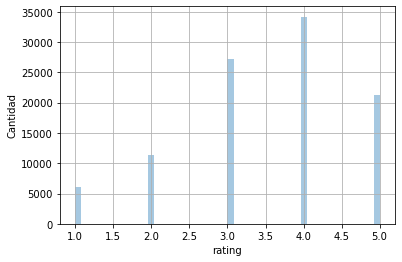

In [5]:
sns.distplot(data['rating'], kde = False)
plt.ylabel('Cantidad')
plt.xlabel('rating')
plt.grid()

In [6]:
data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


**Ejercicio 1**: Calcular el rating promedio (y la desviacion estandar) en Movielens 100K y dar una interpretacion de lo que el valor significa.

In [7]:
rating_promedio = np.mean(data['rating']) # promedio usando np.mean(.)
rating_std = np.std(data['rating']) # standard deviation usando np.std(.)

print('Rating promedio', rating_promedio)
print('Rating std', rating_std)

Rating promedio 3.52986
Rating std 1.1256679707622492


**Ejercicio 2**: Encontrar al usuario que have visto mas peliculas en Movielens 100K. Cuantas peliculas ha visto? Imprimir 10 peliculas vistas por dicho usuario
.

In [8]:
#cantidad de peliculas vista por usuario
count_users = data.user_id.value_counts()

# podemos agregar una nueva columna en data con esta info
data['user_counts'] = data.user_id.map(count_users)

data_orderedbyusers = data.sort_values('user_counts', ascending=False)

print('Usuario que ha visto mas peliculas\n', data_orderedbyusers.iloc[0]) 

# imprimir  10 peliculas vistas por dicho usuario
print('-----------------------------------------')
print('10 peliculas vistas por el usuario con mas peliculas vistas\n', data_orderedbyusers.iloc[0:10]) 

Usuario que ha visto mas peliculas
 user_id              405
item_id             1564
rating                 1
timestamp      885546288
user_counts          737
Name: 81224, dtype: int64
-----------------------------------------
10 peliculas vistas por el usuario con mas peliculas vistas
        user_id  item_id  rating  timestamp  user_counts
81224      405     1564       1  885546288          737
12449      405      171       1  885549544          737
48059      405      317       4  885544911          737
12430      405     1582       1  885548670          737
57089      405      708       1  885546487          737
27282      405      211       1  885547177          737
27284      405     1307       1  885546529          737
27316      405      788       1  885548275          737
12383      405      592       1  885548670          737
71258      405      392       5  885545487          737


## Estudio del dataframe

#### Algunos comandos para analizar el dataframe

**Ejercicio 3**: Encontrar las 10 peliculas que han sido vistas por mas usuarios. 



In [20]:
data.head()  # Lee los 5 primeros registos y muestra el encabezado

,user_id,item_id,rating,timestamp,user_counts,item_counts,movie_counts
0,196,242,3,881250949,39,117,117
1,186,302,3,891717742,92,297,297
2,22,377,1,878887116,128,13,13
3,244,51,2,880606923,238,81,81
4,166,346,1,886397596,20,126,126


In [22]:
data.shape  # para saber la dimension del dataset, devuelve nro. de filas y columnas 10000 filas 7 columnas

(100000, 7)

In [23]:
data.tail()  # lista los ultimos registros del dataframe

,user_id,item_id,rating,timestamp,user_counts,item_counts,movie_counts
99995,880,476,3,880175444,368,160,160
99996,716,204,5,879795543,269,350,350
99997,276,1090,1,874795795,518,37,37
99998,13,225,2,882399156,636,109,109
99999,12,203,3,879959583,51,182,182


In [24]:
data.columns # obtiene los indices de las columnas del dataframe

Index(['user_id', 'item_id', 'rating', 'timestamp', 'user_counts',
       'item_counts', 'movie_counts'],
      dtype='object')

In [25]:
data.columns.values # obtiene los valores de las columnas del dataframe

array(['user_id', 'item_id', 'rating', 'timestamp', 'user_counts',
       'item_counts', 'movie_counts'], dtype=object)

## Resumen estadistico de las variables numéricas


In [26]:
data.describe()  

,user_id,item_id,rating,timestamp,user_counts,item_counts,movie_counts
count,100000.00000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860,8.835289e+08,202.008120,168.071900,168.071900
std,266.61442,330.798356,1.125674,5.343856e+06,139.232713,121.784558,121.784558
min,1.00000,1.000000,1.000000,8.747247e+08,20.000000,1.000000,1.000000
25%,254.00000,175.000000,3.000000,8.794487e+08,98.000000,71.000000,71.000000
50%,447.00000,322.000000,4.000000,8.828269e+08,181.000000,145.000000,145.000000
75%,682.00000,631.000000,4.000000,8.882600e+08,278.000000,239.000000,239.000000
max,943.00000,1682.000000,5.000000,8.932866e+08,737.000000,583.000000,583.000000


In [27]:
data.dtypes  # Devuelve el tipo de dato de cada columna

user_id         int64
item_id         int64
rating          int64
timestamp       int64
user_counts     int64
item_counts     int64
movie_counts    int64
dtype: object

## Valores faltantes - verificar columnas con valores nulos

In [29]:
pd.isnull(data["user_id"])  # devuelve falso si no es nulo verdadero si es nulo.

0        False
1        False
2        False
3        False
4        False
         ...  
99995    False
99996    False
99997    False
99998    False
99999    False
Name: user_id, Length: 100000, dtype: bool

In [49]:
 ## Se hace sumatoria de los valores nulos si es 0 no hay nulos
print("Se hace sumatoria de los valores nulos si es 0 no hay nulos")
print(f" Valores nulos en user_id {pd.isnull(data['user_id']).values.ravel().sum()}")
print(f" Valores nulos en item_id {pd.isnull(data['item_id']).values.ravel().sum()}")
print(f" Valores nulos en rating {pd.isnull(data['rating']).values.ravel().sum()}")
 

    

##Se hace sumatoria de los valores nulos si es 0 no hay nulos
 Valores nulos en user_id 0
 Valores nulos en item_id 0
 Valores nulos en rating 0


## Cuando contienen valores Null o NaN
### Se pueden rellenar dichos campos con valores cero
#### Se hace con data3.fillna(0)
#### Reemplazar con texto  data3.fillna("Desconocido")
#### Reemplazar un campo especìfico  data3["body"].fillna(0)




In [50]:
data2 = data  # Se crea una copia de data en data2 para no afectar el datafreme ofiginal
data2.fillna(0)
# Se puede borrar los reguitros que contienen valores nulos o NAN
# data3 = data
# data3.dropna(axis=0,how="any")

,user_id,item_id,rating,timestamp,user_counts,item_counts,movie_counts
0,196,242,3,881250949,39,117,117
1,186,302,3,891717742,92,297,297
2,22,377,1,878887116,128,13,13
3,244,51,2,880606923,238,81,81
4,166,346,1,886397596,20,126,126
...,...,...,...,...,...,...,...
99995,880,476,3,880175444,368,160,160
99996,716,204,5,879795543,269,350,350
99997,276,1090,1,874795795,518,37,37
99998,13,225,2,882399156,636,109,109


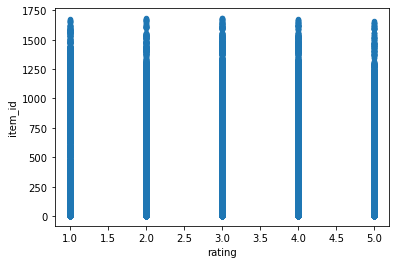

In [62]:
data.plot(kind="scatter", x="rating", y="item_id")  # Scatter Plot

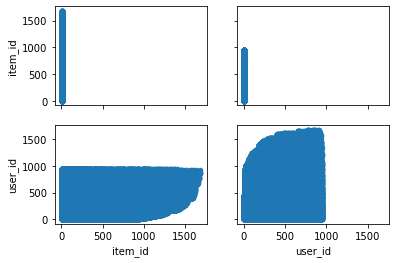

In [66]:
figure, axs = plt.subplots(2,2, sharey=True,sharex=True)
data.plot(kind="scatter", x="rating", y="item_id",ax=axs[0][0])  # Scatter Plot
data.plot(kind="scatter", x="rating", y="user_id",ax=axs[0][1])  # Scatter Plot
data.plot(kind="scatter", x="item_id", y="user_id",ax=axs[1][0])  # Scatter Plot
data.plot(kind="scatter", x="user_id", y="item_id",ax=axs[1][1])  # Scatter Plot

(array([ 6110., 11370., 27145., 34174., 21201.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

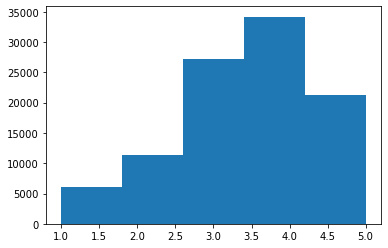

In [69]:
plt.hist(data["rating"],bins = 5)

In [43]:
count_movies = data.item_id.value_counts()
count_movies 
count_movies.describe()


count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: item_id, dtype: float64

**Tarea 1**: Imprimir el porcentaje de usuarios que han visto las 10 peliculas mas populares, e obtener los IDs de las peliculas.

**Tarea 2**: Graficar la distribucion de la cantidad de peliculas que ha visto cada usuario

**Tarea 3**: Graficar la distribucion de la cantidad de usuarios que han visto cada pelicula